## define a 2D-lung segmentation U-Net 
### - use U-Net for automatically segmenting lung tissue from a chest x ray 
### - segmentation is used as mask for computing radiomic features in order to eventually 
### - train a Gradient Boosted Classifier 

####  (- implement dice loss to account for imbalances in dataset)

In [41]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler


def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [42]:
model = unet(input_size=(512,512,1))
model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss,
                  metrics=[dice_coef, 'binary_accuracy'])

model.load_weights('cxr_reg_weights.best.hdf5') 
#from kaggle: https://www.kaggle.com/code/nikhilpandey360/lung-segmentation-from-chest-x-ray-dataset/data
#model.summary()

In [43]:
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

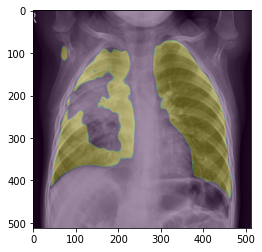

In [45]:
#im = cv2.imread('chest_child_healthy.jpeg')
im = cv2.imread('xray_child_pneumonia.jpg')
image = resize(im, (512, 512,1))
image_pred = np.expand_dims(image,axis=0)
plt.imshow(np.squeeze(image_pred),cmap='gray')

prediction = model.predict(image_pred)
plt.imshow(np.squeeze(prediction),alpha=0.3)

In [23]:
import os
from radiomics import featureextractor 

num_samples = 1000

extractor = featureextractor.RadiomicsFeatureExtractor()

extractor.settings['normalize'] = True
extractor.disableAllFeatures()
extractor.enableFeatureClassByName('glcm')
extractor.enableFeatureClassByName('glrlm')
extractor.enableFeatureClassByName('ngtdm')

print('Extraction config:', extractor.enabledFeatures)

file_list = []

root = 'Downloads/LUNG_XRAY'

for path, dirs, files in os.walk(root):
    for file in files:
        file_list.append(os.path.join(path, file))

Extraction config: {'glcm': [], 'glrlm': [], 'ngtdm': []}


In [24]:
files_pneumonia = [file for file in file_list if 'PNEUMONIA' in file]
print(len(files_pneumonia))
files_normal = [file for file in file_list if 'NORMAL' in file]
print(len(files_normal))

4273
1583


In [25]:
import SimpleITK as sitk

In [431]:
import tensorflow as tf

trained_model = tf.keras.models.load_model('model_pneumonia_det/cnn_2d_binary')

In [27]:
features_normal =  {}
features_pneumonia =  {}
result = {}
names = {}

preds_n = []
preds_p = []


cnt =0

for file in files_normal:
    
    if cnt == num_samples:
        break

    im = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
    image = resize(im, (512, 512))
    image_pred = np.expand_dims(image,axis=0) #ggf durch 255
    segmentation = np.squeeze(model.predict(image_pred))
    
    result= extractor.execute(sitk.GetImageFromArray(image), sitk.GetImageFromArray(segmentation))
    features_normal[cnt]=result.values()

    cnt = cnt+1    
    print(cnt)

cnt = 0

for file in files_pneumonia:

    if cnt == num_samples:
        break
    
    try:
    
        im = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        image = resize(im, (512, 512))
        image_pred = np.expand_dims(image,axis=0)
    
   
        segmentation = np.squeeze(model.predict(image_pred))

        result= extractor.execute(sitk.GetImageFromArray(image), sitk.GetImageFromArray(segmentation))
        cnt = cnt+1
        features_pneumonia[cnt] = result.values()
        names = result.keys() 
        print(cnt)
    except:
        continue

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


5


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


6


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


7


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


8


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


9


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


10


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


11


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


12


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


13


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


14


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


15


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


16


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


17


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


18


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


19


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


20


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


21


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


22


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


23


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


24


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


25


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


26


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


27


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


28


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


29


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


30


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


31


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


32


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


33


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


34


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


35


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


36


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


37


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


38


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


39


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


40


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


41


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


42


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


43


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


44


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


45


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


46


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


47


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


48


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


49


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


50


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


51


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


52


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


53


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


54


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


55


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


56


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


57


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


58


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


59


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


60


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


61


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


62


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


63


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


64


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


65


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


66


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


67


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


68


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


69


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


70


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


71


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


72


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


73


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


74


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


75


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


76


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


77


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


78


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


79


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


80


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


81


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


82


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


83


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


84


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


85


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


86


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


87


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


88


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


89


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


90


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


91


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


92


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


93


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


94


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


95


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


96


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


97


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


98


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


99


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


100


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


101


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


102


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


103


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


104


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


105


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


106


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


107


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


108


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


109


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


110


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


111


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


112


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


113


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


114


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


115


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


116


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


117


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


118


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


119


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


120


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


121


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


122


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


123


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


124


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


125


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


126


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


127


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


128


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


129


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


130


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


131


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


132


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


133


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


134


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


135


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


136


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


137


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


138


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


139


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


140


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


141


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


142


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


143


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


144


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


145


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


146


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


147


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


148


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


149


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


150


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


151


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


152


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


153


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


154


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


155


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


156


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


157


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


158


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


159


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


160


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


161


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


162


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


163


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


164


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


165


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


166


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


167


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


168


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


169


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


170


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


171


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


172


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


173


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


174


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


175


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


176


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


177


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


178


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


179


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


180


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


181


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


182


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


183


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


184


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


185


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


186


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


187


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


188


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


189


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


190


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


191


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


192


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


193


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


194


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


195


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


196


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


197


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


198


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


199


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


200


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


201


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


202


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


203


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


204


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


205


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


206


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


207


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


208


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


209


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


210


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


211


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


212


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


213


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


214


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


215


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


216


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


217


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


218


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


219


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


220


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


221


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


222


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


223


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


224


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


225


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


226


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


227


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


228


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


229


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


230


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


231


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


232


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


233


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


234


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


235


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


236


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


237


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


238


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


239


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


240


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


241


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


242


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


243


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


244


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


245


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


246


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


247


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


248


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


249


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


250


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


251


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


252


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


253


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


254


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


255


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


256


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


257


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


258


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


259


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


260


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


261


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


262


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


263


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


264


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


265


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


266


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


267


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


268


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


269


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


270


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


271


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


272


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


273


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


274


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


275


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


276


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


277


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


278


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


279


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


280


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


281


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


282


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


283


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


284


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


285


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


286


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


287


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


288


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


289


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


290


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


291


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


292


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


293


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


294


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


295


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


296


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


297


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


298


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


299


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


300


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


301


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


302


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


303


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


304


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


305


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


306


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


307


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


308


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


309


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


310


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


311


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


312


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


313


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


314


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


315


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


316


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


317


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


318


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


319


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


320


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


321


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


322


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


323


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


324


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


325


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


326


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


327


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


328


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


329


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


330


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


331


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


332


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


333


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


334


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


335


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


336


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


337


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


338


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


339


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


340


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


341


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


342


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


343


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


344


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


345


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


346


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


347


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


348


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


349


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


350


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


351


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


352


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


353


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


354


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


355


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


356


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


357


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


358


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


359


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


360


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


361


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


362


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


363


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


364


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


365


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


366


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


367


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


368


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


369


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


370


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


371


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


372


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


373


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


374


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


375


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


376


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


377


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


378


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


379


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


380


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


381


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


382


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


383


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


384


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


385


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


386


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


387


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


388


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


389


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


390


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


391


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


392


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


393


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


394


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


395


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


396


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


397


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


398


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


399


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


400


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


401


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


402


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


403


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


404


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


405


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


406


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


407


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


408


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


409


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


410


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


411


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


412


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


413


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


414


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


415


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


416


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


417


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


418


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


419


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


420


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


421


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


422


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


423


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


424


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


425


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


426


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


427


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


428


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


429


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


430


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


431


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


432


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


433


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


434


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


435


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


436


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


437


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


438


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


439


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


440


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


441


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


442


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


443


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


444


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


445


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


446


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


447


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


448


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


449


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


450


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


451


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


452


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


453


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


454


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


455


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


456


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


457


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


458


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


459


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


460


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


461


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


462


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


463


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


464


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


465


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


466


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


467


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


468


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


469


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


470


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


471


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


472


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


473


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


474


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


475


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


476


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


477


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


478


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


479


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


480


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


481


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


482


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


483


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


484


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


485


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


486


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


487


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


488


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


489


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


490


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


491


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


492


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


493


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


494


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


495


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


496


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


497


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


498


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


499


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


500


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


501


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


502


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


503


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


504


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


505


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


506


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


507


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


508


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


509


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


510


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


511


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


512


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


513


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


514


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


515


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


516


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


517


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


518


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


519


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


520


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


521


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


522


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


523


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


524


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


525


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


526


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


527


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


528


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


529


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


530


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


531


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


532


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


533


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


534


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


535


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


536


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


537


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


538


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


539


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


540


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


541


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


542


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


543


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


544


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


545


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


546


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


547


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


548


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


549


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


550


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


551


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


552


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


553


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


554


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


555


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


556


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


557


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


558


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


559


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


560


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


561


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


562


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


563


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


564


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


565


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


566


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


567


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


568


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


569


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


570


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


571


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


572


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


573


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


574


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


575


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


576


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


577


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


578


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


579


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


580


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


581


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


582


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


583


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


584


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


585


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


586


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


587


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


588


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


589


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


590


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


591


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


592


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


593


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


594


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


595


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


596


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


597


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


598


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


599


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


600


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


601


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


602


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


603


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


604


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


605


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


606


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


607


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


608


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


609


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


610


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


611


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


612


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


613


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


614


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


615


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


616


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


617


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


618


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


619


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


620


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


621


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


622


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


623


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


624


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


625


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


626


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


627


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


628


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


629


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


630


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


631


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


632


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


633


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


634


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


635


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


636


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


637


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


638


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


639


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


640


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


641


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


642


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


643


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


644


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


645


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


646


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


647


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


648


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


649


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


650


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


651


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


652


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


653


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


654


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


655


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


656


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


657


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


658


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


659


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


660


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


661


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


662


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


663


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


664


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


665


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


666


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


667


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


668


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


669


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


670


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


671


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


672


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


673


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


674


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


675


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


676


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


677


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


678


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


679


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


680


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


681


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


682


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


683


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


684


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


685


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


686


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


687


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


688


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


689


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


690


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


691


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


692


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


693


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


694


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


695


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


696


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


697


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


698


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


699


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


700


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


701


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


702


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


703


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


704


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


705


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


706


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


707


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


708


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


709


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


710


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


711


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


712


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


713


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


714


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


715


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


716


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


717


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


718


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


719


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


720


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


721


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


722


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


723


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


724


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


725


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


726


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


727


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


728


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


729


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


730


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


731


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


732


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


733


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


734


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


735


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


736


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


737


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


738


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


739


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


740


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


741


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


742


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


743


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


744


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


745


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


746


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


747


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


748


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


749


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


750


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


751


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


752


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


753


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


754


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


755


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


756


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


757


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


758


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


759


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


760


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


761


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


762


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


763


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


764


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


765


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


766


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


767


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


768


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


769


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


770


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


771


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


772


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


773


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


774


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


775


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


776


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


777


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


778


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


779


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


780


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


781


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


782


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


783


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


784


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


785


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


786


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


787


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


788


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


789


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


790


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


791


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


792


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


793


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


794


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


795


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


796


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


797


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


798


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


799


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


800


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


801


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


802


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


803


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


804


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


805


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


806


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


807


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


808


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


809


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


810


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


811


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


812


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


813


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


814


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


815


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


816


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


817


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


818


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


819


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


820


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


821


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


822


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


823


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


824


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


825


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


826


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


827


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


828


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


829


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


830


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


831


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


832


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


833


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


834


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


835


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


836


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


837


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


838


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


839


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


840


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


841


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


842


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


843


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


844


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


845


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


846


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


847


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


848


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


849


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


850


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


851


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


852


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


853


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


854


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


855


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


856


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


857


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


858


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


859


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


860


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


861


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


862


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


863


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


864


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


865


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


866


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


867


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


868


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


869


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


870


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


871


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


872


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


873


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


874


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


875


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


876


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


877


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


878


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


879


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


880


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


881


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


882


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


883


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


884


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


885


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


886


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


887


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


888


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


889


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


890


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


891


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


892


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


893


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


894


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


895


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


896


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


897


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


898


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


899


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


900


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


901


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


902


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


903


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


904


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


905


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


906


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


907


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


908


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


909


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


910


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


911


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


912


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


913


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


914


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


915


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


916


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


917


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


918


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


919


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


920


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


921


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


922


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


923


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


924


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


925


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


926


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


927


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


928


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


929


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


930


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


931


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


932


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


933


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


934


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


935


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


936


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


937


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


938


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


939


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


940


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


941


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


942


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


943


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


944


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


945


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


946


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


947


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


948


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


949


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


950


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


951


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


952


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


953


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


954


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


955


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


956


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


957


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


958


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


959


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


960


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


961


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


962


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


963


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


964


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


965


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


966


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


967


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


968


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


969


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


970


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


971


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


972


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


973


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


974


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


975


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


976


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


977


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


978


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


979


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


980


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


981


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


982


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


983


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


984


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


985


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


986


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


987


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


988


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


989


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


990


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


991


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


992


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


993


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


994


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


995


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


996


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


997


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


998


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


999


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


1000


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


5


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


6


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


7


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


8


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


9


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


10


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


11


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


12


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


13


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


14


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


15


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


16


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


17


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


18


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


19


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


20


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


21


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


22


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


23


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


24


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


25


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


26


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


27


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


28


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


29


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


30


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


31


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


32


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


33


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


34


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


35


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


36


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


37


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


38


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


39


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


40


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


41


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


42


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


43


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


44


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


45


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


46


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


47


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


48


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


49


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


50


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


51


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


52


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


53


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


54


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


55


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


56


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


57


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


58


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


59


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


60


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


61


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


62


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


63


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


64


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


65


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


66


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


67


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


68


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


69


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


70


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


71


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


72


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


73


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


74


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


75


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


76


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


77


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


78


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


79


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


80


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


81


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


82


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


83


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


84


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


85


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


86


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


87


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


88


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


89


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


90


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


91


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


92


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


93


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


94


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


95


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


96


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


97


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


98


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


99


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


100


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


101


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


102


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


103


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


104


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


105


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


106


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


107


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


108


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


109


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


110


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


111


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


112


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


113


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


114


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


115


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


116


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


117


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


118


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


119


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


120


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


121


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


122


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


123


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


124


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


125


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


126


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


127


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


128


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


129


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


130


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


131


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


132


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


133


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


134


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


135


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


136


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


137


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


138


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


139


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


140


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


141


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


142


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


143


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


144


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


145


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


146


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


147


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


148


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


149


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


150


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


151


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


152


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


153


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


154


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


155


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


156


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


157


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


158


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


159


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


160


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


161


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


162


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


163


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


164


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


165


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


166


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


167


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


168


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


169


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


170


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


171


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


172


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


173


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


174


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


175


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


176


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


177


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


178


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


179


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


180


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


181


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


182


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


183


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


184


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


185


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


186


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


187


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


188


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


189


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


190


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


191


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


192


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


193


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


194


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


195


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


196


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


197


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


198


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


199


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


200


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


201


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


202


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


203


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


204


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


205


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


206


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


207


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


208


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


209


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


210


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


211


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


212


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


213


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


214


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


215


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


216


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


217


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


218


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


219


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


220


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


221


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


222


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


223


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


224


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


225


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


226


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


227


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


228


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


229


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


230


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


231


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


232


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


233


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


234


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


235


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


236


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


237


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


238


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


239


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


240


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


241


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


242


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


243


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


244


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


245


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


246


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


247


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


248


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


249


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


250


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


251


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


252


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


253


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


254


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


255


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


256


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


257


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


258


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


259


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


260


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


261


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


262


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


263


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


264


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


265


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


266


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


267


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


268


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


269


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


270


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


271


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


272


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


273


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


274


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


275


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


276


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


277


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


278


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


279


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


280


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


281


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


282


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


283


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


284


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


285


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


286


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


287


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


288


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


289


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


290


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


291


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


292


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


293


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


294


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


295


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


296


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


297


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


298


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


299


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


300


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


301


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


302


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


303


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


304


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


305


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


306


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


307


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


308


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


309


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


310


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


311


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


312


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


313


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


314


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


315


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


316


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


317


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


318


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


319


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


320


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


321


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


322


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


323


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


324


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


325


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


326


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


327


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


328


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


329


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


330


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


331


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


332


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


333


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


334


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


335


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


336


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


337


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


338


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


339


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


340


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


341


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


342


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


343


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


344


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


345


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


346


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


347


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


348


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


349


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


350


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


351


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


352


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


353


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


354


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


355


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


356


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


357


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


358


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


359


/home/miracum/miniconda3/envs/tensorflow/lib/python3.8/site-packages/radiomics/glcm.py:258: RuntimeWarning: Mean of empty slice
  return numpy.nanmean(ac, 1)
/home/miracum/miniconda3/envs/tensorflow/lib/python3.8/site-packages/radiomics/glcm.py:294: RuntimeWarning: Mean of empty slice
  return numpy.nanmean(cp, 1)
/home/miracum/miniconda3/envs/tensorflow/lib/python3.8/site-packages/radiomics/glcm.py:312: RuntimeWarning: Mean of empty slice
  return numpy.nanmean(cs, 1)
/home/miracum/miniconda3/envs/tensorflow/lib/python3.8/site-packages/radiomics/glcm.py:329: RuntimeWarning: Mean of empty slice
  return numpy.nanmean(ct, 1)
/home/miracum/miniconda3/envs/tensorflow/lib/python3.8/site-packages/radiomics/glcm.py:344: RuntimeWarning: Mean of empty slice
  return numpy.nanmean(cont, 1)
/home/miracum/miniconda3/envs/tensorflow/lib/python3.8/site-packages/radiomics/glcm.py:374: RuntimeWarning: Mean of empty slice
  return numpy.nanmean(corr, (1, 2, 3))
/home/miracum/miniconda3/envs/tensorflow

360


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


361


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


362


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


363


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


364


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


365


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


366


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


367


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


368


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


369


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


370


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


371


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


372


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


373


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


374


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


375


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


376


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


377


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


378


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


379


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


380


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


381


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


382


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


383


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


384


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


385


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


386


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


387


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


388


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


389


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


390


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


391


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


392


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


393


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


394


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


395


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


396


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


397


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


398


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


399


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


400


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


401


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


402


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


403


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


404


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


405


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


406


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


407


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


408


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


409


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


410


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


411


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


412


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


413


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


414


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


415


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


416


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


417


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


418


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


419


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


420


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


421


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


422


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


423


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


424


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


425


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


426


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


427


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


428


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


429


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


430


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


431


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


432


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


433


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


434


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


435


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


436


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


437


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


438


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


439


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


440


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


441


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


442


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


443


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


444


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


445


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


446


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


447


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


448


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


449


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


450


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


451


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


452


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


453


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


454


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


455


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


456


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


457


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


458


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


459


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


460


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


461


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


462


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


463


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


464


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


465


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


466


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


467


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


468


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


469


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


470


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


471


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


472


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


473


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


474


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


475


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


476


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


477


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


478


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


479


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


480


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


481


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


482


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


483


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


484


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


485


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


486


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


487


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


488


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


489


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


490


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


491


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


492


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


493


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


494


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


495


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


496


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


497


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


498


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


499


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


500


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


501


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


502


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


503


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


504


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


505


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


506


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


507


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


508


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


509


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


510


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


511


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


512


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


513


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


514


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


515


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


516


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


517


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


518


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


519


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


520


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


521


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


522


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


523


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


524


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


525


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


526


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


527


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


528


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


529


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


530


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


531


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


532


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


533


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


534


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


535


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


536


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


537


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


538


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


539


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


540


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


541


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


542


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


543


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


544


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


545


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


546


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


547


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


548


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


549


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


550


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


551


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


552


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


553


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


554


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


555


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


556


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


557


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


558


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


559


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


560


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


561


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


562


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


563


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


564


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


565


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


566


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


567


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


568


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


569


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


570


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


571


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


572


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


573


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


574


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


575


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


576


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


577


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


578


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


579


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


580


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


581


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


582


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


583


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


584


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


585


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


586


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


587


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


588


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


589


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


590


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


591


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


592


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


593


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


594


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


595


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


596


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


597


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


598


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


599


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


600


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


601


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


602


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


603


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


604


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


605


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


606


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


607


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


608


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


609


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


610


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


611


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


612


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


613


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


614


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


615


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


616


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


617


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


618


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


619


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


620


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


621


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


622


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


623


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


624


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


625


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


626


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


627


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


628


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


629


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


630


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


631


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


632


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


633


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


634


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


635


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


636


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


637


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


638


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


639


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


640


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


641


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


642


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


643


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


644


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


645


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


646


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


647


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


648


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


649


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


650


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


651


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


652


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


653


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


654


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


655


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


656


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


657


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


658


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


659


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


660


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


661


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


662


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


663


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


664


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


665


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


666


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


667


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


668


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


669


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


670


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


671


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


672


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


673


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


674


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


675


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


676


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


677


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


678


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


679


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


680


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


681


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


682


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


683


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


684


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


685


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


686


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


687


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


688


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


689


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


690


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


691


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


692


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


693


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


694


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


695


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


696


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


697


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


698


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


699


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


700


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


701


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


702


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


703


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


704


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


705


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


706


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


707


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


708


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


709


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


710


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


711


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


712


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


713


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


714


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


715


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


716


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


717


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


718


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


719


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


720


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


721


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


722


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


723


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


724


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


725


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


726


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


727


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


728


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


729


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


730


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


731


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


732


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


733


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


734


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


735


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


736


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


737


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


738


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


739


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


740


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


741


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


742


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


743


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


744


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


745


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


746


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


747


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


748


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


749


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


750


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


751


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


752


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


753


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


754


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


755


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


756


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


757


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


758


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


759


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


760


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


761


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


762


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


763


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


764


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


765


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


766


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


767


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


768


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


769


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


770


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


771


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


772


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


773


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


774


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


775


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


776


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


777


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


778


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


779


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


780


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


781


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


782


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


783


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


784


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


785


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


786


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


787


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


788


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


789


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


790


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


791


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


792


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


793


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


794


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


795


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


796


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


797


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


798


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


799


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


800


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


801


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


802


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


803


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


804


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


805


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


806


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


807


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


808


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


809


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


810


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


811


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


812


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


813


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


814


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


815


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


816


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


817


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


818


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


819


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


820


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


821


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


822


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


823


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


824


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


825


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


826


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


827


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


828


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


829


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


830


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


831


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


832


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


833


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


834


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


835


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


836


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


837


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


838


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


839


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


840


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


841


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


842


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


843


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


844


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


845


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


846


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


847


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


848


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


849


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


850


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


851


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


852


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


853


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


854


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


855


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


856


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


857


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


858


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


859


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


860


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


861


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


862


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


863


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


864


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


865


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


866


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


867


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


868


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


869


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


870


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


871


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


872


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


873


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


874


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


875


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


876


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


877


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


878


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


879


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


880


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


881


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


882


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


883


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


884


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


885


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


886


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


887


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


888


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


889


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


890


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


891


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


892


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


893


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


894


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


895


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


896


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


897


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


898


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


899


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


900


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


901


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


902


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


903


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


904


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


905


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


906


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


907


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


908


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


909


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


910


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


911


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


912


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


913


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


914


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


915


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


916


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


917


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


918


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


919


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


920


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


921


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


922


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


923


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


924


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


925


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


926


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


927


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


928


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


929


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


930


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


931


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


932


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


933


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


934


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


935


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


936


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


937


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


938


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


939


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


940


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


941


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


942


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


943


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


944


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


945


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


946


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


947


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


948


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


949


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


950


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


951


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


952


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


953


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


954


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


955


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


956


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


957


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


958


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


959


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


960


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


961


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


962


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


963


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


964


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


965


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


966


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


967


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


968


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


969


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


970


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


971


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


972


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


973


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


974


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


975


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


976


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


977


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


978


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


979


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


980


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


981


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


982


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


983


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


984


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


985


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


986


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


987


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


988


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


989


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


990


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


991


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


992


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


993


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


994


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


995


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


996


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


997


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


998


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


999


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


1000


In [46]:
features_all = pd.DataFrame([features_pneumonia.values(),features_normal.values()] )

names_df = pd.DataFrame(names)
names_np = names_df.to_numpy()

start = 22 #discard random logs from results
names_np = names_np[start:]
#features_n = pd.DataFrame(features_normal.values())

In [47]:
X = []
Y = []

for row in range(features_all.shape[0]):
    for col in range(features_all.shape[1]):
        test = features_all[col][row]
        test = pd.DataFrame(test)
        test = test.to_numpy()
        test = test[start:]
        X.append(test)
        Y.append(row)
        
X = np.squeeze(X)

In [97]:
#from sklearn.preprocessing import StandardScaler
#sc = StandardScaler()
#X_t = sc.fit_transform(X[22:])

In [48]:
from sklearn.feature_selection import VarianceThreshold

sel = VarianceThreshold(threshold=0.4)
sel.fit_transform(X)

importance_mask = sel.get_support()
X_new = X[:,importance_mask]

valid_features = names_np[importance_mask]

### glrlm: https://pyradiomics.readthedocs.io/en/latest/features.html#module-radiomics.glrlm

In [49]:
print('valid features:',valid_features,'X_shape:',np.shape(X_new))

valid features: [['original_glrlm_GrayLevelNonUniformity']
 ['original_glrlm_LongRunEmphasis']
 ['original_glrlm_LongRunHighGrayLevelEmphasis']
 ['original_glrlm_LongRunLowGrayLevelEmphasis']
 ['original_glrlm_RunEntropy']
 ['original_glrlm_RunLengthNonUniformity']
 ['original_glrlm_RunVariance']
 ['original_ngtdm_Busyness']
 ['original_ngtdm_Coarseness']] X_shape: (2000, 9)


In [50]:
from sklearn.model_selection import train_test_split

In [51]:
from sklearn.ensemble import HistGradientBoostingClassifier

X_train, X_test, y_train, y_test = train_test_split(X_new, Y, test_size=0.33, random_state=42)

In [52]:
clf = HistGradientBoostingClassifier().fit(X_train, y_train)
#clf = GradientBoostingClassifier(n_estimators=200, learning_rate=1,max_depth=2, random_state=0).fit(X_train, y_train)
clf.score(X_test, y_test)

0.8333333333333334

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


[0]
predicted class: pneumonia


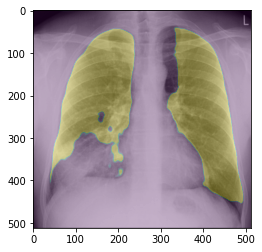

In [56]:
#file = 'chest_xray_xnat.jpg'
#file = 'chest_child_healthy.jpeg'
#file = 'xray_child_pneumonia.jpg'
file = 'xray_radioapaedia.jpeg'


im = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
image = resize(im, (512, 512))
image_pred = np.expand_dims(image,axis=0)
    
segmentation = np.squeeze(model.predict(image_pred))

result= extractor.execute(sitk.GetImageFromArray(image), sitk.GetImageFromArray(segmentation))
features=result.values()

plt.imshow(image, cmap='gray')
plt.imshow(segmentation,alpha=0.3)

features = pd.DataFrame(features).to_numpy()
valid_features = features[start:]
valid_features = valid_features[importance_mask]

valid_features = np.reshape(valid_features,(1,9))

result = clf.predict(valid_features)
print(result)
classes = ['pneumonia', 'normal']

print('predicted class:', classes[int(result)])

In [345]:
features = pd.DataFrame(features).to_numpy()
valid_features = features[start:]
valid_features = valid_features[importance_mask]
valid_features = np.reshape(valid_features,(1,9))

result = clf.predict(valid_features)
print(result)

[0]


In [57]:
import warnings
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets
from sklearn.exceptions import ConvergenceWarning

# different learning rate schedules and momentum parameters
params = [
    {
        "solver": "sgd",
        "learning_rate": "constant",
        "momentum": 0,
        "learning_rate_init": 0.2,
    },
    {
        "solver": "sgd",
        "learning_rate": "constant",
        "momentum": 0.9,
        "nesterovs_momentum": False,
        "learning_rate_init": 0.2,
    },
    {
        "solver": "sgd",
        "learning_rate": "constant",
        "momentum": 0.9,
        "nesterovs_momentum": True,
        "learning_rate_init": 0.2,
    },
    {
        "solver": "sgd",
        "learning_rate": "invscaling",
        "momentum": 0,
        "learning_rate_init": 0.2,
    },
    {
        "solver": "sgd",
        "learning_rate": "invscaling",
        "momentum": 0.9,
        "nesterovs_momentum": True,
        "learning_rate_init": 0.2,
    },
    {
        "solver": "sgd",
        "learning_rate": "invscaling",
        "momentum": 0.9,
        "nesterovs_momentum": False,
        "learning_rate_init": 0.2,
    },
    {"solver": "adam", "learning_rate_init": 0.01},
]

labels = [
    "constant learning-rate",
    "constant with momentum",
    "constant with Nesterov's momentum",
    "inv-scaling learning-rate",
    "inv-scaling with momentum",
    "inv-scaling with Nesterov's momentum",
    "adam",
]

plot_args = [
    {"c": "red", "linestyle": "-"},
    {"c": "green", "linestyle": "-"},
    {"c": "blue", "linestyle": "-"},
    {"c": "red", "linestyle": "--"},
    {"c": "green", "linestyle": "--"},
    {"c": "blue", "linestyle": "--"},
    {"c": "black", "linestyle": "-"},
]


learning on dataset chest_radiomics
training: constant learning-rate
Training set score: 0.829104
Training set loss: 0.402426
training: constant with momentum
Training set score: 0.812687
Training set loss: 0.410924
training: constant with Nesterov's momentum
Training set score: 0.832836
Training set loss: 0.386644
training: inv-scaling learning-rate
Training set score: 0.632090
Training set loss: 0.685541
training: inv-scaling with momentum
Training set score: 0.708955
Training set loss: 0.617914
training: inv-scaling with Nesterov's momentum
Training set score: 0.708209
Training set loss: 0.618503
training: adam
Training set score: 0.827612
Training set loss: 0.372415


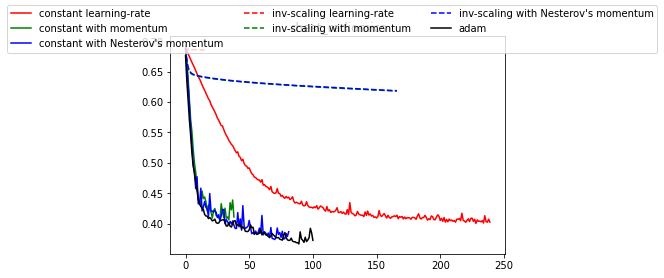

In [58]:
def plot_on_dataset(X, y, ax, name):
    # for each dataset, plot learning for each learning strategy
    print("\nlearning on dataset %s" % name)
    ax.set_title(name)

    X = MinMaxScaler().fit_transform(X)
    mlps = []
    if name == "digits":
        # digits is larger but converges fairly quickly
        max_iter = 15
    else:
        max_iter = 400

    for label, param in zip(labels, params):
        print("training: %s" % label)
        mlp = MLPClassifier(random_state=0, max_iter=max_iter, **param)

        # some parameter combinations will not converge as can be seen on the
        # plots so they are ignored here
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore", category=ConvergenceWarning, module="sklearn"
            )
            mlp.fit(X, y)

        mlps.append(mlp)
        print("Training set score: %f" % mlp.score(X, y))
        print("Training set loss: %f" % mlp.loss_)
    for mlp, label, args in zip(mlps, labels, plot_args):
        ax.plot(mlp.loss_curve_, label=label, **args)


fig, ax = plt.subplots()
plot_on_dataset(X_train,y_train, ax=ax, name='chest_radiomics')

fig.legend(ax.get_lines(), labels, ncol=3, loc="upper center")
plt.show()